In [1]:
# -*- coding: utf-8 -*-

import numpy as np  # Para operaciones numéricas (aunque sklearn lo usa más internamente)
from sklearn.datasets import fetch_20newsgroups # Para obtener un dataset de ejemplo clásico
from sklearn.model_selection import train_test_split # Para dividir nuestros datos
from sklearn.feature_extraction.text import TfidfVectorizer # Para convertir texto en vectores numéricos (TF-IDF)
from sklearn.svm import LinearSVC # El modelo SVM (versión lineal, buena para texto)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Para evaluar qué tan bien lo hicimos
import matplotlib.pyplot as plt # Para graficar
import seaborn as sns # Para hacer gráficos más bonitos (la matriz de confusión)


In [2]:

# ## 3. Cargar los Datos de Texto
#
# Usaremos el dataset "20 Newsgroups". Es una colección de ~20,000 mensajes
# de grupos de noticias, clasificados en 20 temas diferentes.
#
# Para simplificar, elegiremos solo dos temas que sean bastante distintos,
# por ejemplo, béisbol (`rec.sport.baseball`) y espacio (`sci.space`).
# Nuestro objetivo será entrenar un modelo que pueda distinguir entre
# un texto que habla de béisbol y uno que habla de ciencia espacial.

# Define las categorías que nos interesan
categories = ['rec.sport.baseball', 'sci.space']

# Carga los datos SÓLO de esas categorías
# 'subset='all'' carga tanto entrenamiento como prueba, los dividiremos nosotros mismos después.
# 'shuffle=True' mezcla los datos.
# 'random_state' asegura que la mezcla sea la misma cada vez que ejecutamos (reproducibilidad).
print("Cargando dataset 20 Newsgroups para las categorías:", categories)
newsgroups_data = fetch_20newsgroups(subset='all', categories=categories,
                                     shuffle=True, random_state=42,
                                     remove=('headers', 'footers', 'quotes')) # Quitamos partes que pueden dar pistas "fáciles"

print(f"¡Listo! Se cargaron {len(newsgroups_data.data)} documentos.")

# Exploremos un poco los datos
print("\nCategorías disponibles (etiquetas numéricas):", newsgroups_data.target)
print("Nombres de las categorías:", newsgroups_data.target_names)

# Veamos un ejemplo de texto y su categoría
print("\n--- Ejemplo de Documento ---")
print("Texto:", newsgroups_data.data[0][:500], "...") # Mostramos los primeros 500 caracteres
print("Categoría (numérica):", newsgroups_data.target[0])
print("Categoría (nombre):", newsgroups_data.target_names[newsgroups_data.target[0]])



Cargando dataset 20 Newsgroups para las categorías: ['rec.sport.baseball', 'sci.space']
¡Listo! Se cargaron 1981 documentos.

Categorías disponibles (etiquetas numéricas): [0 0 0 ... 1 0 1]
Nombres de las categorías: ['rec.sport.baseball', 'sci.space']

--- Ejemplo de Documento ---
Texto: 
Do you really have *that* much information on him?  Really?


I don't know.  You tell me.  What percentage of players reach or 
exceed their MLE's *in their rookie season*?  We're talking about
1993, you know.


If that were your purpose, maybe.  Offerman spent 1992 getting 
acclimated, if you will.  The Dodgers as a team paid a big price
that season.  Perhaps they will reap the benefits down the road.
Do you really think they would have done what they did if they
were competing for a pennant?
 ...
Categoría (numérica): 0
Categoría (nombre): rec.sport.baseball


In [3]:

# ## 4. Dividir los Datos: Entrenamiento y Prueba
#
# ¡Fundamental! No podemos evaluar el modelo con los mismos datos que usó para
# aprender, sería como hacer un examen con las respuestas vistas.
#
# Dividimos nuestros datos en dos conjuntos:
# *   **Conjunto de Entrenamiento (Training Set):** Lo usamos para que el modelo SVM "aprenda" los patrones (aprox. 75% de los datos).
# *   **Conjunto de Prueba (Test Set):** Lo guardamos y lo usamos AL FINAL para evaluar qué tan bien generaliza el modelo a datos nuevos (aprox. 25% de los datos).

# X son los textos (datos), y son las etiquetas (categorías)
X = newsgroups_data.data
y = newsgroups_data.target

# Dividimos
# test_size=0.25 significa que el 25% de los datos será para prueba.
# random_state asegura que la división sea la misma cada vez.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Tamaño del conjunto de Entrenamiento: {len(X_train)} documentos")
print(f"Tamaño del conjunto de Prueba: {len(X_test)} documentos")



Tamaño del conjunto de Entrenamiento: 1485 documentos
Tamaño del conjunto de Prueba: 496 documentos


In [4]:
# ## 5. Vectorización: Convertir Texto en Números (TF-IDF)
#
# Las SVM (y la mayoría de modelos de ML) no entienden palabras, ¡entienden números!
# Necesitamos convertir cada texto en un vector numérico. Usaremos **TF-IDF**.
#
# **Intuición de TF-IDF:**
# *   **TF (Term Frequency):** ¿Qué tan seguido aparece una palabra en *un* documento? (Más veces = más importante *para ese* doc).
# *   **IDF (Inverse Document Frequency):** ¿En cuántos documentos aparece una palabra? (Si aparece en *muchos* docs, como "el" o "la", es menos útil para *distinguir* entre docs -> menos peso).
# *   **TF-IDF:** Combina ambos. Da más peso a palabras que son frecuentes en un documento específico pero raras en el resto de la colección. ¡Son palabras discriminativas!
#
# **Proceso:**
# 1.  **Ajustar (Fit):** El `TfidfVectorizer` aprende el vocabulario (todas las palabras únicas) y calcula los pesos IDF **usando SOLO el conjunto de entrenamiento**.
# 2.  **Transformar (Transform):** Convierte los textos (tanto de entrenamiento como de prueba) en una matriz numérica basada en el vocabulario y los pesos aprendidos.

print("\nCreando el vectorizador TF-IDF...")
# Podemos añadir parámetros como stop_words='english' para quitar palabras comunes
# o max_features=5000 para limitar el tamaño del vocabulario
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# 1. Aprende vocabulario y pesos IDF del CONJUNTO DE ENTRENAMIENTO
print("Ajustando el vectorizador a los datos de entrenamiento...")
X_train_tfidf = vectorizer.fit_transform(X_train)

# 2. Transforma el CONJUNTO DE PRUEBA usando el mismo vectorizador ya ajustado
print("Transformando los datos de prueba...")
X_test_tfidf = vectorizer.transform(X_test)

print("\n¡Vectorización completa!")
print("Forma de la matriz TF-IDF de entrenamiento (documentos, características/palabras):", X_train_tfidf.shape)
print("Forma de la matriz TF-IDF de prueba:", X_test_tfidf.shape)
# Nota: El número de características (columnas) es el tamaño del vocabulario aprendido.



Creando el vectorizador TF-IDF...
Ajustando el vectorizador a los datos de entrenamiento...
Transformando los datos de prueba...

¡Vectorización completa!
Forma de la matriz TF-IDF de entrenamiento (documentos, características/palabras): (1485, 5000)
Forma de la matriz TF-IDF de prueba: (496, 5000)


## 6. Entrenar el Modelo SVM


Ahora viene la parte central. Vamos a crear un clasificador SVM y a "entrenarlo".
Usaremos `LinearSVC`, una implementación de SVM eficiente para casos donde
las clases se pueden separar razonablemente bien con una "línea" (o hiperplano
en muchas dimensiones), lo cual suele funcionar bien para texto.


**¿Qué hace `.fit()`?**

El modelo analiza los vectores TF-IDF (`X_train_tfidf`) y sus etiquetas
correspondientes (`y_train`) para encontrar el "mejor hiperplano" que separe
los puntos de la clase 0 (béisbol) de los puntos de la clase 1 (espacio),
maximizando el "margen" entre ellos.

In [ ]:



print("\nEntrenando el modelo LinearSVC...")

# Creamos una instancia del clasificador
# C es un parámetro de regularización, controla el balance entre margen y errores.
# Un C más alto intenta clasificar todo correctamente (puede sobreajustar).
# Un C más bajo permite más errores a cambio de un margen más grande (puede generalizar mejor).
# Dejamos el valor por defecto por ahora.
model = LinearSVC(C=1.0, random_state=42, dual=True, max_iter=2000) # dual=True recomendado cuando n_samples > n_features, ajustado max_iter

# Entrenamos el modelo con los datos de entrenamiento vectorizados y sus etiquetas
model.fit(X_train_tfidf, y_train)

print("¡Modelo entrenado!")



Entrenando el modelo LinearSVC...
¡Modelo entrenado!


## 7. Realizar Predicciones en el Conjunto de Prueba
El modelo ya aprendió. Ahora, vamos a usarlo para predecir la categoría
de los textos del conjunto de prueba (`X_test_tfidf`), que el modelo
¡nunca ha visto antes!


In [ ]:


print("\nRealizando predicciones sobre el conjunto de prueba...")
y_pred = model.predict(X_test_tfidf)

# Veamos algunas predicciones comparadas con las etiquetas reales
print("\nPrimeras 10 predicciones vs etiquetas reales:")
print(f"Predicciones: {y_pred[:10]}")
print(f"Reales:       {y_test[:10]}")
# (Recordemos: 0 = baseball, 1 = space)



Realizando predicciones sobre el conjunto de prueba...

Primeras 10 predicciones vs etiquetas reales:
Predicciones: [0 0 0 0 0 1 0 1 0 1]
Reales:       [0 0 0 0 0 1 0 1 1 1]



## 8. Evaluar el Rendimiento del Modelo
¿Qué tan buenas fueron las predicciones? Necesitamos métricas para evaluarlo objetivamente.
*   **Accuracy (Exactitud):** Porcentaje total de predicciones correctas. Simple, pero puede ser engañoso si una clase es mucho más frecuente que otra (no es nuestro caso aquí, ya que elegimos 2 clases).
*   **Matriz de Confusión:** Una tabla que nos dice:
    *   Cuántos de béisbol se clasificaron bien como béisbol (Verdaderos Negativos - TN).
    *   Cuántos de béisbol se clasificaron mal como espacio (Falsos Positivos - FP).
    *   Cuántos de espacio se clasificaron mal como béisbol (Falsos Negativos - FN).
    *   Cuántos de espacio se clasificaron bien como espacio (Verdaderos Positivos - TP).
    (Asumiendo béisbol=0 (negativo), espacio=1 (positivo)).
*   **Precisión (Precision):** De todos los que *dijo* que eran "espacio", ¿cuántos realmente lo eran? 

`TP / (TP + FP)`. 

Importante cuando el coste de un Falso Positivo es alto.

*   **Recall (Sensibilidad):** De todos los que *realmente* eran "espacio", ¿cuántos encontró? 

`TP / (TP + FN)`. 

Importante cuando el coste de un Falso Negativo es alto.


*   **F1-Score:** La media armónica de Precisión y Recall. Un buen balance entre ambas.


--- Evaluación del Modelo ---
Accuracy (Exactitud): 0.9274

Matriz de Confusión:


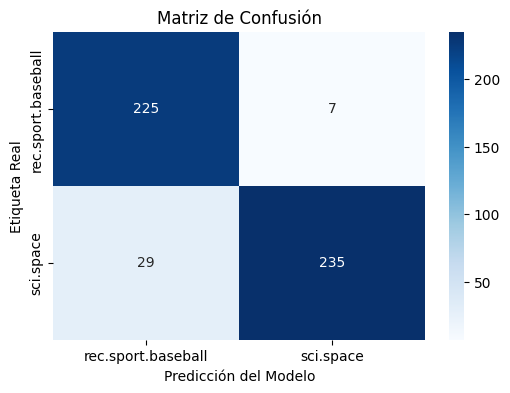


Reporte de Clasificación:
                    precision    recall  f1-score   support

rec.sport.baseball       0.89      0.97      0.93       232
         sci.space       0.97      0.89      0.93       264

          accuracy                           0.93       496
         macro avg       0.93      0.93      0.93       496
      weighted avg       0.93      0.93      0.93       496



In [ ]:


print("\n--- Evaluación del Modelo ---")

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Exactitud): {accuracy:.4f}") # Formateado a 4 decimales

# 2. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
# Usamos seaborn para una visualización más clara
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=newsgroups_data.target_names,
            yticklabels=newsgroups_data.target_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

# 3. Reporte de Clasificación (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=newsgroups_data.target_names))

In [ ]:

# ## 9. Discusión y Próximos Pasos
#
# **Interpretación:**
# *   La *accuracy* nos da una idea general del rendimiento.
# *   La *matriz de confusión* nos muestra exactamente dónde se equivoca el modelo. ¿Confunde más "béisbol" con "espacio" o viceversa?
# *   El *reporte de clasificación* detalla la Precisión, Recall y F1 para cada clase. Esto es útil para entender si el modelo funciona igual de bien para ambas categorías.
#
# **¿Qué podríamos hacer ahora? (Ideas para lingüistas)**
# *   **Analizar Errores:** Mirar algunos de los textos que el modelo clasificó mal. ¿Por qué se confundió? ¿Usan lenguaje ambiguo? ¿Hay jerga específica?
# *   **Probar con Otros Datos:** Aplicar esta misma técnica a *tus propios* datos de texto (¡solo necesitas textos y sus etiquetas!). Podría ser clasificación de género textual, análisis de sentimiento, detección de autoría...
# *   **Mejorar el Modelo:**
#     *   **Preprocesamiento:** Probar lemmatización o stemming, usar una lista de stopwords más específica para el dominio.
#     *   **Vectorización:** Incluir bigramas o trigramas (`ngram_range=(1, 2)` en `TfidfVectorizer`) para capturar frases cortas. Ajustar `max_features`.
#     *   **Modelo SVM:** Probar diferentes valores del parámetro `C` en `LinearSVC`. Incluso probar otros "kernels" de SVM (como `SVC(kernel='rbf')`), aunque `LinearSVC` suele ser un buen punto de partida para texto.
#     *   **Comparar:** Comparar SVM con otros algoritmos como Naive Bayes (`MultinomialNB`) o Regresión Logística (`LogisticRegression`).
#
# **Fortalezas de SVM para Texto:**
# *   Funciona bien con muchas "características" (muchas palabras en el vocabulario TF-IDF).
# *   Es efectivo en espacios de alta dimensionalidad.
# *   Es robusto cuando hay una separación clara entre clases (incluso si es compleja).
#
# **¡Felicidades!** Has entrenado y evaluado tu primer clasificador de texto con SVM. Este es un punto de partida poderoso para muchas tareas de análisis de texto computacional relevantes para la lingüística.

# Fin del Notebook